In [8]:
from main.compiling.compilers.AncillaPerCheckCompiler import AncillaPerCheckCompiler
from main.compiling.noise.models.CircuitLevelNoise import CircuitLevelNoise
from main.compiling.syndrome_extraction.extractors.ancilla_per_check.mixed.CxCyCzExtractor import CxCyCzExtractor
from main.codes.tic_tac_toe.HoneycombCode import HoneycombCode
from main.codes.tic_tac_toe.gauge_honeycomb_code import GaugeHoneycombCode
from main.codes.tic_tac_toe.FloquetColourCode import FloquetColourCode
from main.codes.tic_tac_toe.TicTacToeCode import TicTacToeCode
from main.utils.enums import State
from main.building_blocks.pauli import Pauli
from main.building_blocks.pauli.PauliLetter import PauliLetter
import stim
import sinter 
import matplotlib.pyplot as plt
import numpy as np
from beliefmatching import BeliefMatchingSinterDecoder
from main.utils.Colour import Blue, Green, Red
import os
from phenomenological_noise_experiments.threshold_plot import *


## Import and compress data

In [18]:

os.system(f"cp resume_15_3/data.csv resume_15_3/data_backup.csv")
os.system(f"sinter combine resume_15_3/data.csv > resume_15_3/compress_data.csv")
os.system(f"rm resume_15_3/data.csv")
os.system(f"mv resume_15_3/compress_data.csv resume_15_3/data.csv")
samples = sinter.stats_from_csv_files('resume_15_3/data.csv')

biases = []
for sample in samples:
    if sample.json_metadata['bias'] not in biases:
        biases.append(sample.json_metadata['bias'])
biases.sort()


## PyMatching Experiments

### Depolarizing vs measurement noise

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16, 16, 16, 16, 16, 16, 16, 16]
[0.00145, 0.0019, 0.00235, 0.0028, 0.00325, 0.0037, 0.00415, 0.0046, 0.00505, 0.0055, 0.00595, 0.0064, 0.00685, 0.0073, 0.00775, 0.0082, 0.00865, 0.0091, 0.00955, 0.00145, 0.0019, 0.00235, 0.0028, 0.00325, 0.0037, 0.00415, 0.0046, 0.00505, 0.0055, 0.00595, 0.0064, 0.00685, 0.0073, 0.00775, 0.0082, 0.00865, 0.0091, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008, 0.0085]
[6e-05, 0.00029, 0.00072, 0.00174, 0.00372, 0.00641, 0.0112, 0.01791, 0.02597, 0.0384, 0.05348, 0.06907, 0.089, 0.11523444248643792, 0.14068024920020206, 0.17088779494143608, 0.20255816295699466, 0.22980942189029804, 0.2646779803942237, 0.0, 0.0, 7e-05, 0.00013, 0.00046, 0.00109, 0.00252, 0.00531, 0.00964, 0.01749, 0.02944, 0.04825, 0.07336, 0.10733596532635283, 0.14354670066029762, 0.19208021179518955, 0.2387925315136006, 0.28401001660054587, 0.00348, 0.008

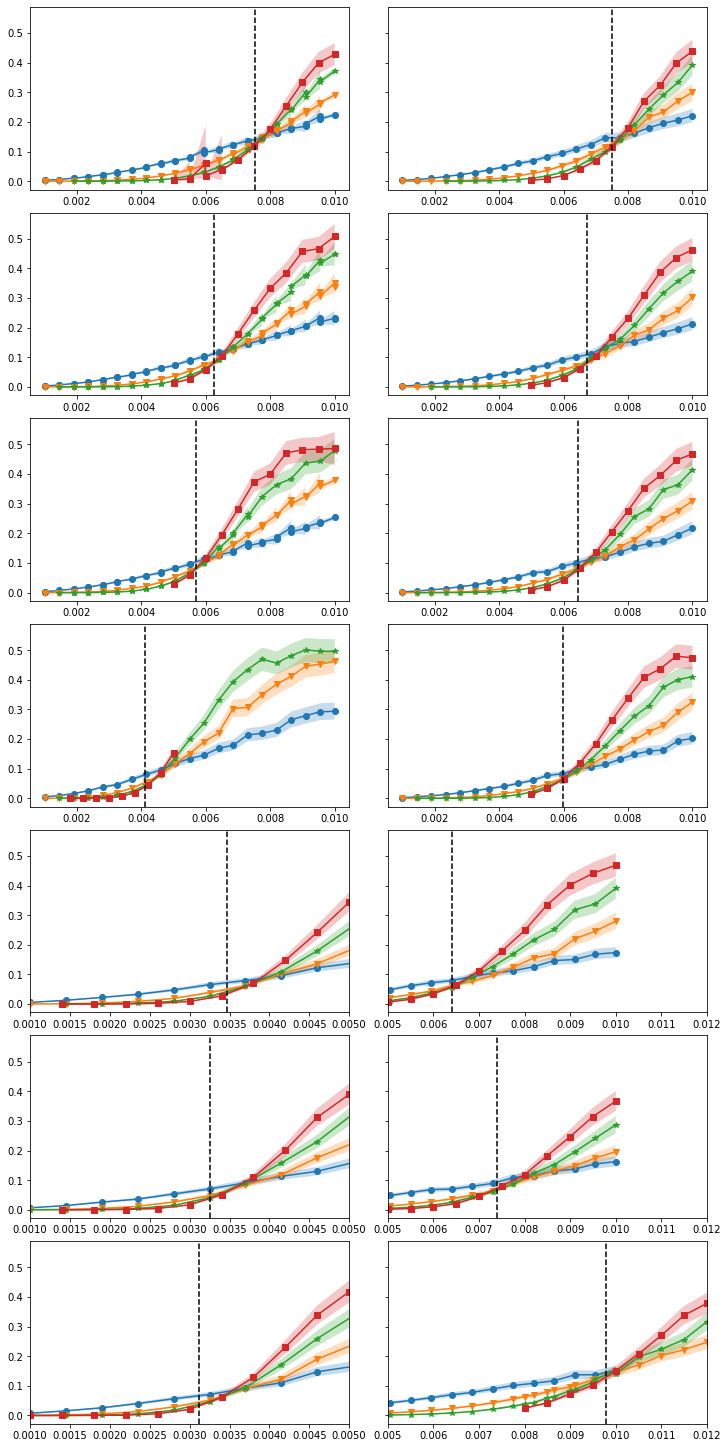

In [10]:
fig, axis = plt.subplots(7,2,figsize=(10,20), sharey=True, constrained_layout=True)
thresholds_hcc = dict()
thresholds_fcc = dict()
def plot_threshold(ax, stats,filter_func):#, filter_func, x_func):
    sinter.plot_error_rate(
        ax=ax,
        stats=stats,
        group_func= lambda stat: f"d={stat.json_metadata['distance']}",
        filter_func = filter_func,
        x_func=lambda stat: stat.json_metadata['p'])
for index,bias in enumerate(biases):


    filter_func_hcc = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'HoneycombCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'
    filter_func_fcc = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'FloquetColourCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'
    plot_threshold(axis[index][0], samples, filter_func_hcc)
    plot_threshold(axis[index][1], samples, filter_func_fcc)
    if bias < 7: 
        thresholds_hcc[bias] = get_one_threshold(samples, filter_func_hcc, 1,0.001,0.01,5) 
        thresholds_fcc[bias] = get_one_threshold(samples, filter_func_fcc, 1,0.001,0.01,5)
        axis[index][0].axvline(x=thresholds_hcc[bias], color="black", linestyle="dashed")
        axis[index][1].axvline(x=thresholds_fcc[bias], color="black", linestyle="dashed")        


    else:
        thresholds_hcc[bias] = get_one_threshold(samples, filter_func_hcc , 1,0.001,0.005,5)
        thresholds_fcc[bias] = get_one_threshold(samples, filter_func_fcc, 1,0.004,0.011,5)
        axis[index][0].axvline(x=thresholds_hcc[bias], color="black", linestyle="dashed")
        axis[index][1].axvline(x=thresholds_fcc[bias], color="black", linestyle="dashed")       
        axis[index][0].set_xlim(0.001,0.005)
        axis[index][1].set_xlim(0.005,0.012)


(0.0, 19000.0)

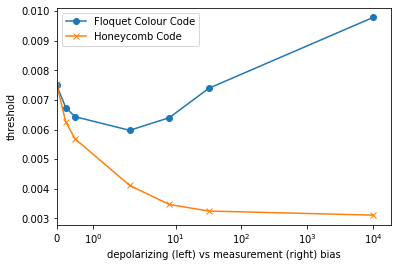

In [4]:
biases = [bias for bias in thresholds_fcc]
biases.sort()
plot_thresholds_fcc = [thresholds_fcc[bias] for bias in biases]
plot_thresholds_hcc = [thresholds_hcc[bias] for bias in biases]

plt.plot(biases, plot_thresholds_fcc,label='Floquet Colour Code', marker='o')
plt.plot(biases, plot_thresholds_hcc, label='Honeycomb Code', marker='x')
plt.xscale('symlog')
plt.xlabel('depolarizing (left) vs measurement (right) bias')
plt.ylabel('threshold')
plt.legend()
plt.xlim(0,19000)

## Depolarizing vs dephasing noise

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16, 16, 16, 16, 16, 16, 16, 16]
[0.01, 0.0067, 0.00765, 0.0086, 0.00955, 0.0105, 0.01145, 0.0124, 0.01335, 0.0143, 0.01, 0.0067, 0.00765, 0.0086, 0.00955, 0.0105, 0.01145, 0.0124, 0.01335, 0.0143, 0.0067, 0.00765, 0.0086, 0.00955, 0.0105, 0.01145, 0.0124, 0.01335]
[0.07113290454053366, 0.01369657449217631, 0.023050052856551914, 0.041697846512014636, 0.05786540934419203, 0.08750428522454577, 0.12165822635731952, 0.15242018537590113, 0.19574780058651026, 0.24116132053383282, 0.04932651241376074, 0.00313, 0.00804, 0.017840325532633226, 0.03920799843168006, 0.07098497495826377, 0.11260957518543493, 0.1672787979966611, 0.24162044851700024, 0.29654614139233676, 0.00079, 0.00321, 0.00906, 0.023902324489316742, 0.05350386357580602, 0.10762607626076261, 0.1902359641985354, 0.2791117996385231]
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16, 16, 16, 16, 16, 16, 16, 16, 

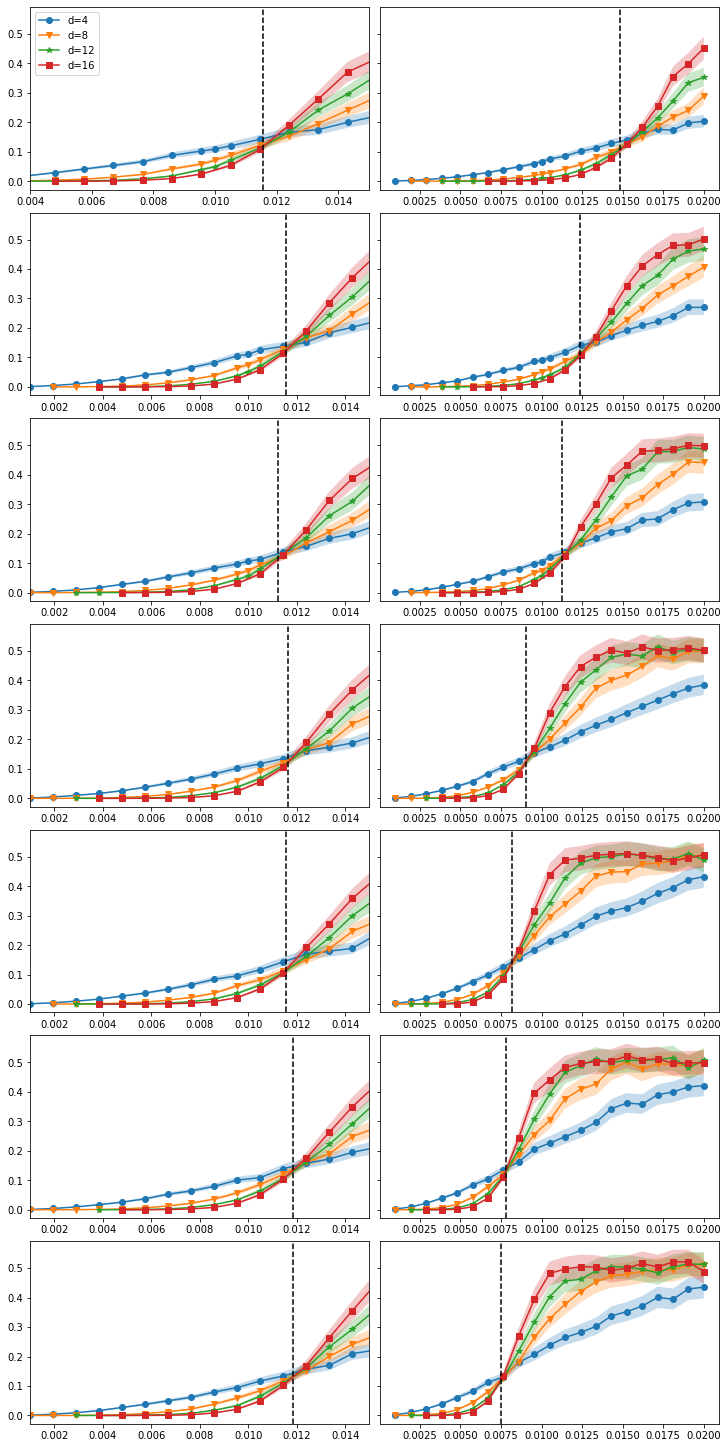

In [5]:
fig, axis = plt.subplots(7,2,figsize=(10,20), sharey=True, constrained_layout=True)
thresholds_hcc = dict()
thresholds_fcc = dict()

for index,bias in enumerate(biases):
    filter_func_hcc = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'HoneycombCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'depolarizing_vs_dephasing'
    filter_func_fcc = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'FloquetColourCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'depolarizing_vs_dephasing'
    plot_threshold(axis[index][0], samples,filter_func_hcc)
    plot_threshold(axis[index][1], samples, filter_func_fcc)
    if bias == 0: 
        thresholds_hcc[bias] = get_one_threshold(samples, filter_func_hcc,1,0.006,0.015,5)
        thresholds_fcc[bias] = get_one_threshold(samples, filter_func_fcc, 1,0.006,0.02,5)
        axis[index][0].axvline(x=thresholds_hcc[bias], color="black", linestyle="dashed")
        axis[index][1].axvline(x=thresholds_fcc[bias], color="black", linestyle="dashed")        
        axis[index][0].set_xlim(0.004,0.015)
    else:
        thresholds_hcc[bias] = get_one_threshold(samples,filter_func_hcc, 1,0.006,0.015,5)
        thresholds_fcc[bias] = get_one_threshold(samples, filter_func_fcc,1,0.005,0.015,5)
        axis[index][0].axvline(x=thresholds_hcc[bias], color="black", linestyle="dashed")
        axis[index][1].axvline(x=thresholds_fcc[bias], color="black", linestyle="dashed")       
        axis[index][0].set_xlim(0.001,0.015)
    axis[0][0].legend()
    print(thresholds_hcc)

(0.0, 19000.0)

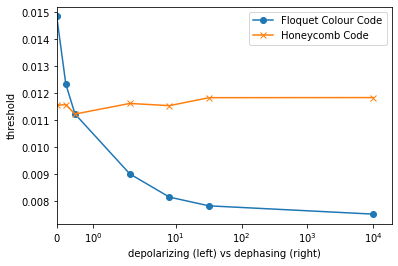

In [6]:

biases = [bias for bias in thresholds_fcc]
biases.sort()
plot_thresholds_fcc = [thresholds_fcc[bias] for bias in biases]
plot_thresholds_hcc = [thresholds_hcc[bias] for bias in biases]

plt.plot(biases, plot_thresholds_fcc,label='Floquet Colour Code', marker='o')
plt.plot(biases, plot_thresholds_hcc, label='Honeycomb Code', marker='x')
plt.xscale('symlog')
plt.xlabel('depolarizing (left) vs dephasing (right)')
plt.ylabel('threshold')
plt.legend()
plt.xlim(0,19000)

## Depolarizing vs Y noise

[8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12, 16, 16, 16, 16, 16, 16, 16]
[0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013]
[0.016373124592302675, 0.028713323438748717, 0.04626545603869143, 0.07733910221741482, 0.10282724620183117, 0.14120054570259208, 0.17263339070567987, 0.21888865413057257, 0.00438, 0.011199237875800341, 0.025182472597757657, 0.05051094890510949, 0.09087752799236178, 0.1464682940921566, 0.2106508875739645, 0.2745578231292517, 0.00141, 0.00449, 0.013954525810993545, 0.03616442280148954, 0.07531254707034192, 0.15051488221187756, 0.24470134874759153]
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
[0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.018, 0.017, 0.019, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.008, 0.009, 0.01, 0.011

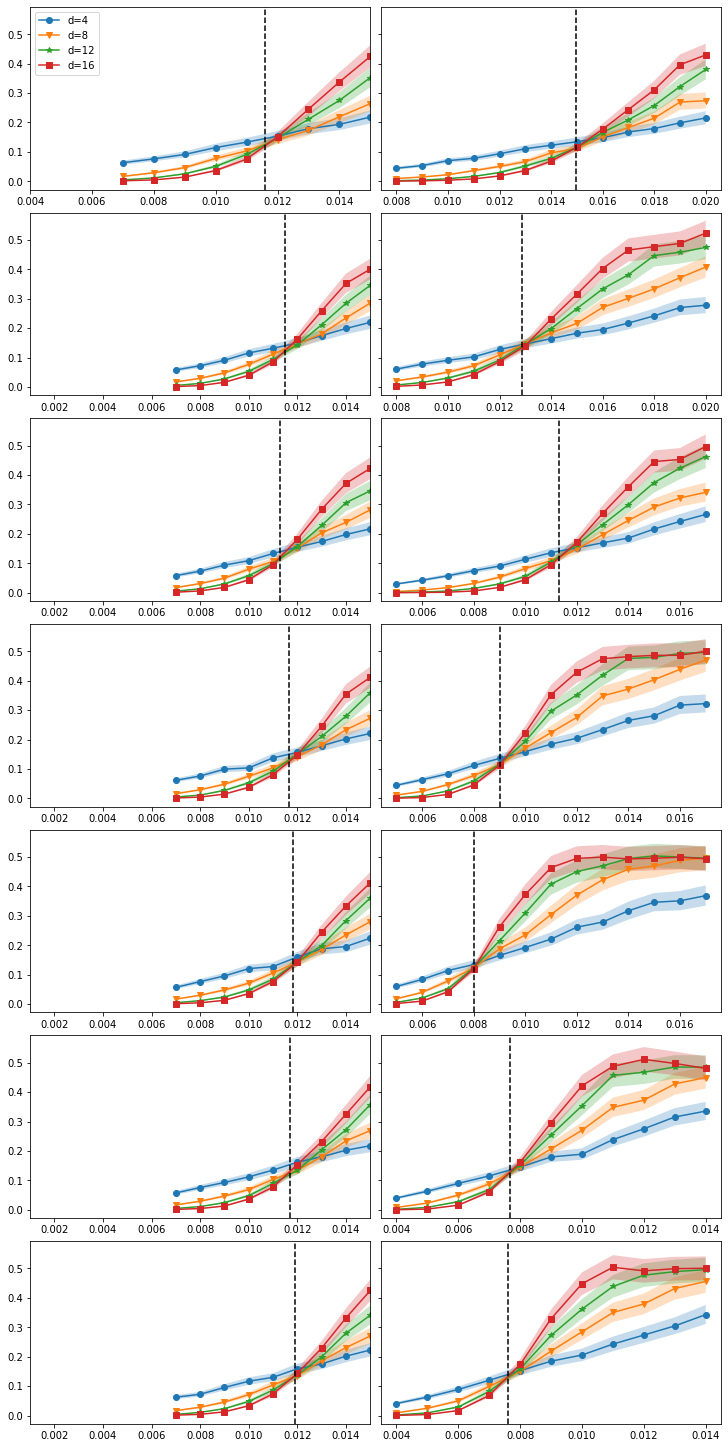

In [19]:
fig, axis = plt.subplots(7,2,figsize=(10,20), sharey=True, constrained_layout=True)
thresholds_hcc = dict()
thresholds_fcc = dict()

for index,bias in enumerate(biases):
    filter_func_hcc = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'HoneycombCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'depolarizing_vs_y'
    filter_func_fcc = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'FloquetColourCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'depolarizing_vs_y'
    plot_threshold(axis[index][0], samples,filter_func_hcc)
    plot_threshold(axis[index][1], samples, filter_func_fcc)
    if bias == 0: 
        thresholds_hcc[bias] = get_one_threshold(samples, filter_func_hcc,1,0.006,0.015,5)
        thresholds_fcc[bias] = get_one_threshold(samples, filter_func_fcc, 1,0.006,0.02,5)
        axis[index][0].axvline(x=thresholds_hcc[bias], color="black", linestyle="dashed")
        axis[index][1].axvline(x=thresholds_fcc[bias], color="black", linestyle="dashed")        
        axis[index][0].set_xlim(0.004,0.015)
    else:
        thresholds_hcc[bias] = get_one_threshold(samples,filter_func_hcc, 1,0.006,0.015,5)
        thresholds_fcc[bias] = get_one_threshold(samples, filter_func_fcc,1,0.005,0.015,5)
        axis[index][0].axvline(x=thresholds_hcc[bias], color="black", linestyle="dashed")
        axis[index][1].axvline(x=thresholds_fcc[bias], color="black", linestyle="dashed")       
        axis[index][0].set_xlim(0.001,0.015)
    axis[0][0].legend()
    print(thresholds_hcc)

(0.0, 19000.0)

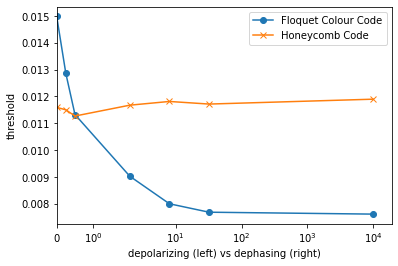

In [20]:

biases = [bias for bias in thresholds_fcc]
biases.sort()
plot_thresholds_fcc = [thresholds_fcc[bias] for bias in biases]
plot_thresholds_hcc = [thresholds_hcc[bias] for bias in biases]

plt.plot(biases, plot_thresholds_fcc,label='Floquet Colour Code', marker='o')
plt.plot(biases, plot_thresholds_hcc, label='Honeycomb Code', marker='x')
plt.xscale('symlog')
plt.xlabel('depolarizing (left) vs dephasing (right)')
plt.ylabel('threshold')
plt.legend()
plt.xlim(0,19000)

12
8
{0.001: 0.0, 0.00195: 0.0001, 0.0029: 0.0011, 0.00385: 0.0022, 0.0048: 0.0083, 0.0067: 0.043329532497149374, 0.00575: 0.020942408376963352, 0.00765: 0.07186440677966102, 0.0086: 0.11006289308176101, 0.00955: 0.17320703653585928, 0.0105: 0.2934472934472934, 0.0124: 0.3388888888888889, 0.01145: 0.2961038961038961, 0.01335: 0.4279661016949153, 0.0143: 0.5102040816326531, 0.01525: 0.5, 0.0162: 0.4861111111111111, 0.01715: 0.5, 0.0181: 0.505, 0.01905: 0.4927536231884058, 0.02: 0.5377358490566038}
12
8
{0.001: 0.0, 0.00195: 0.0001, 0.0029: 0.0006, 0.00385: 0.0041, 0.0048: 0.0091, 0.00575: 0.017985188668155638, 0.0067: 0.04101326899879373, 0.00955: 0.16995447647951442, 0.00765: 0.085995085995086, 0.0086: 0.12964930924548354, 0.0105: 0.23529411764705882, 0.01145: 0.2725, 0.0124: 0.37538461538461537, 0.01335: 0.3993055555555556, 0.0143: 0.43829787234042555, 0.01525: 0.49047619047619045, 0.0162: 0.5, 0.01715: 0.4346153846153846, 0.0181: 0.46558704453441296, 0.01905: 0.4590909090909091, 0.02

TypeError: '>' not supported between instances of 'float' and 'NoneType'

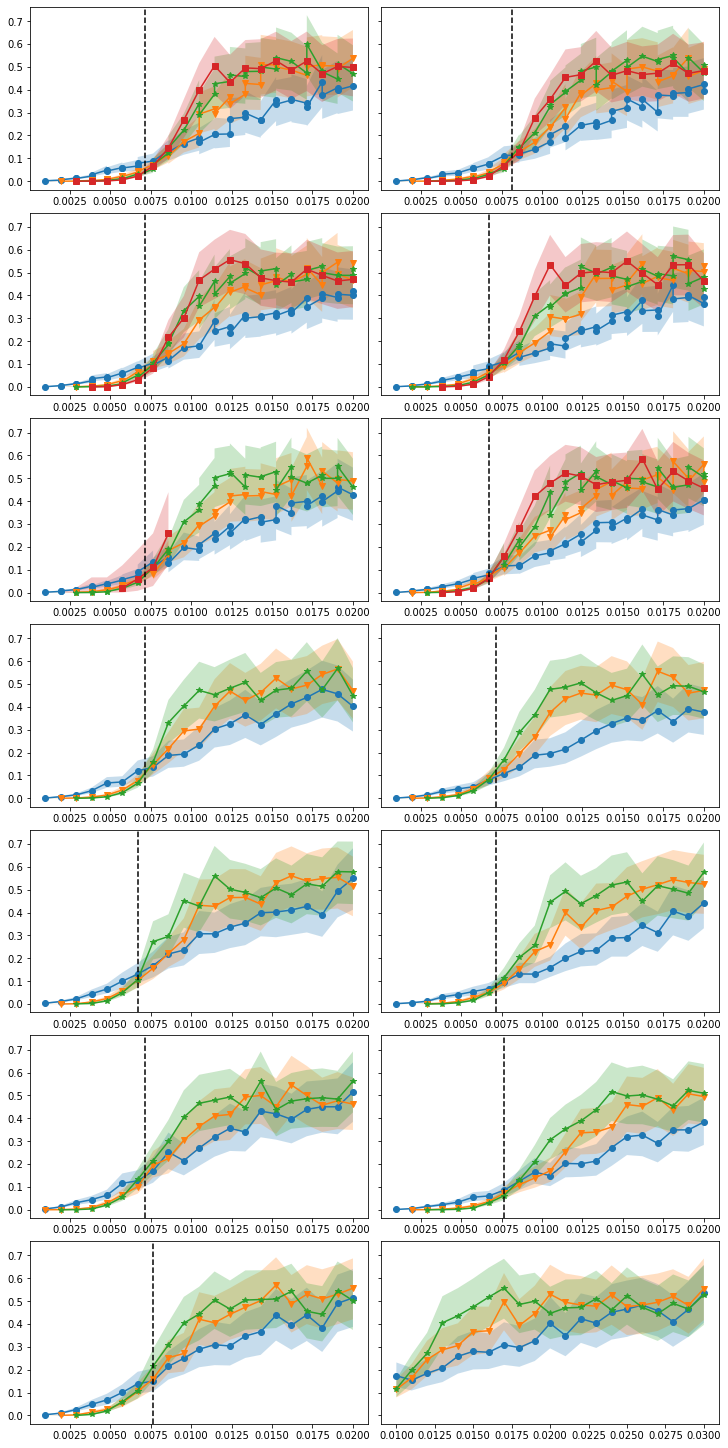

In [12]:
fig, axis = plt.subplots(7,2,figsize=(10,20), sharey=True, constrained_layout=True)
thresholds_hcc = dict()
thresholds_fcc = dict()
filter_func_hcc = lambda s : s.decoder == 'beliefmatching' and s.json_metadata['code'] == 'HoneycombCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'
filter_func_fcc = lambda s : s.decoder == 'beliefmatching' and s.json_metadata['code'] == 'FloquetColourCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'
for index,bias in enumerate(biases):
    plot_threshold(axis[index][0], samples, filter_func_hcc)
    plot_threshold(axis[index][1], samples, filter_func_fcc)
    thresholds_hcc[bias] = get_one_approximate_threshold(samples, filter_func_hcc, 1,0.007,0.009,5,13)
    thresholds_fcc[bias] = get_one_approximate_threshold(samples, filter_func_fcc, 1,0.006,0.009,5,13)
    axis[index][0].axvline(x=thresholds_hcc[bias], color="black", linestyle="dashed")
    axis[index][1].axvline(x=thresholds_fcc[bias], color="black", linestyle="dashed")  


(0.0, 19000.0)

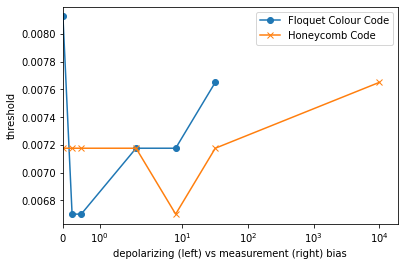

In [13]:
biases = [bias for bias in thresholds_fcc]
biases.sort()
plot_thresholds_fcc = [thresholds_fcc[bias] for bias in biases]
plot_thresholds_hcc = [thresholds_hcc[bias] for bias in biases]

plt.plot(biases, plot_thresholds_fcc,label='Floquet Colour Code', marker='o')
plt.plot(biases, plot_thresholds_hcc, label='Honeycomb Code', marker='x')
plt.xscale('symlog')
plt.xlabel('depolarizing (left) vs measurement (right) bias')
plt.ylabel('threshold')
plt.legend()
plt.xlim(0,19000)